In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [7]:
import pandas as pd

In [12]:
image_path = fr"C:\Users\surri\PycharmProjects\ML_Assignment2\image.jpg" 
image = cv2.imread(image_path)  # Load the image 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
image.shape

(480, 640, 3)

In [14]:
x, y = (240,120)
patch_size = 50
patch = image[y:y+patch_size, x:x+patch_size,:]

# org_patch = patch
# img = cv2.rectangle(image, (x, y), (x + patch_size, y + patch_size), (255, 255, 0), 5)

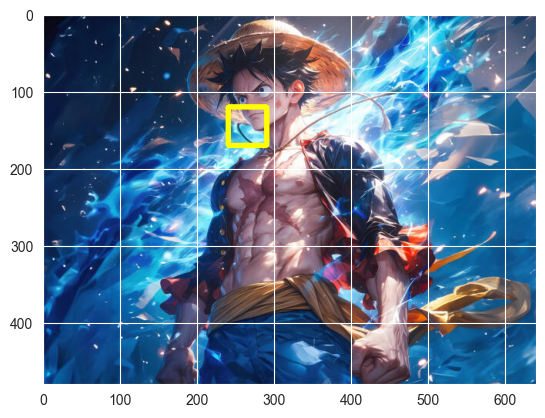

In [15]:
plt.imshow(img)

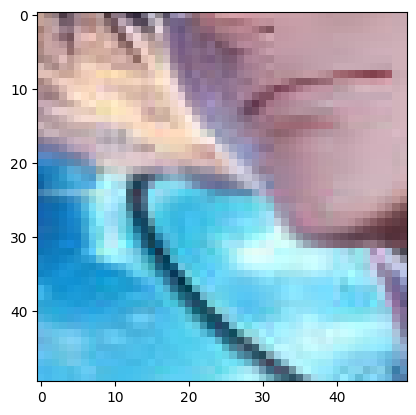

In [15]:
plt.imshow(patch)

Let us decompose org_patch as WH. W is of shape (50, r) and H is of shape (r, 50). We can write the above equation as:
A = WH

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features
    
    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    
    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [18]:
R = patch[:,:,0]
G = patch[:,:,1]
B = patch[:,:,2]

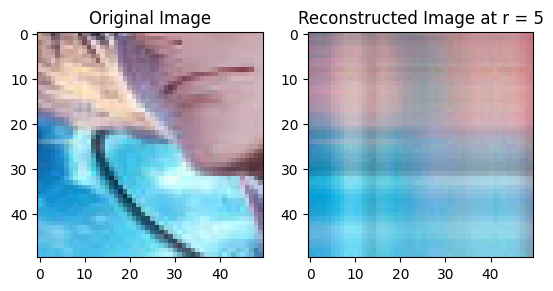

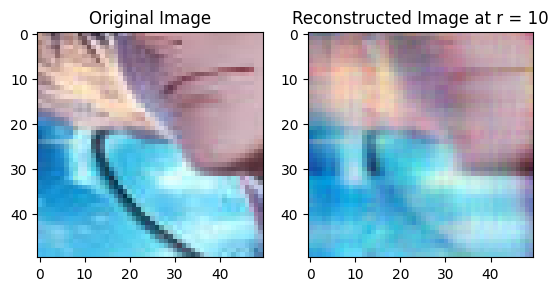

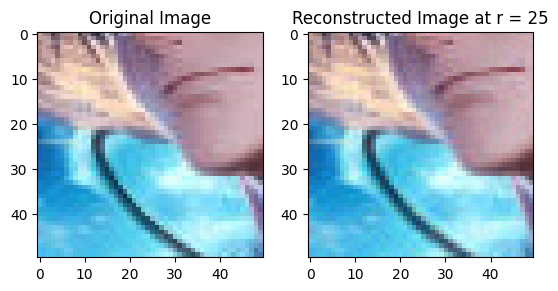

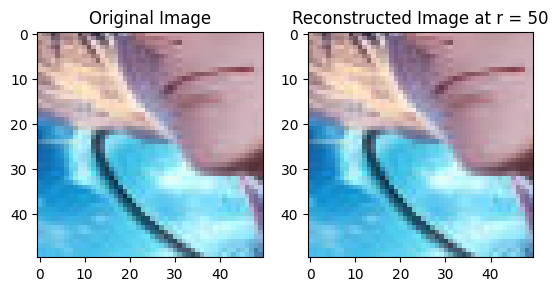

In [21]:
results = []
for k in [5,10,25,50]:
    W_r, H_r, loss_r = factorize(torch.from_numpy(R), k, device=device)
    W_g, H_g, loss_g = factorize(torch.from_numpy(G), k, device=device)
    W_b, H_b, loss_b = factorize(torch.from_numpy(B), k, device=device)
    reconstructed_image = np.clip(np.stack([(W_r@H_r).cpu().detach().numpy(),(W_g@H_g).cpu().detach().numpy(),(W_b@H_b).cpu().detach().numpy()],axis =2), 0, 255).astype(np.uint8)
    loss = loss_r + loss_g + loss_b
    plt.subplot(1, 2, 1)
    plt.imshow(patch)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title(f"Reconstructed Image at r = {k}")
    rmse = torch.sqrt(loss).mean()
    psnr = 10 * torch.log10(255.0 / loss.mean())
    results.append([k, rmse, psnr])
    plt.show()

In [22]:
for i in results:
    print(f"For r = {i[0]}, RMSE = {i[1].cpu().detach().numpy()}, PSNR = {i[2].cpu().detach().numpy()}")

For r = 5, RMSE = 71.15167999267578, PSNR = -12.978301048278809
For r = 10, RMSE = 56.06086730957031, PSNR = -10.907793998718262
For r = 25, RMSE = 26.739850997924805, PSNR = -4.47777795791626
For r = 50, RMSE = 4.3172526359558105, PSNR = 11.361251831054688
